# View the simulated spectrum of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 19th 2017
- update : January 24th


This reads all the simulated fits spectra in order to build a single fits file of all simulated spectra.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [3]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [4]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [5]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [6]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [7]:
%load_ext Cython

In [8]:
from IPython.display import Image, display

In [9]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [10]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [11]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [12]:

object_name='HD14943'

In [13]:
outputfitsfile='AllSimSpectra_'+object_name+'.fits'

In [14]:
#ensure_dir(outputdir)

In [15]:
#simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01'
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195'

## Read the simulated spectra

In [16]:
inputsim_filelist=os.listdir(simspecdir) 

In [17]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [18]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD14943_Nev100_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev101_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev102_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev103_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev104_y2016_m01_aver_spectra.fits']


In [19]:
print re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m01_aver_spectra.fits',inputsim_filelist[0])

['100']


In [20]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [21]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m01_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [22]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [23]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [24]:
print indexes_simfiles

[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195  92  93  94  95  96  97  98  99]


In [25]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [26]:
sorted_simindexes

array([ 96,  97,  98,  99, 100, 101, 102, 103,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95])

In [27]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [28]:
print sorted_simnumbers # check

[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195]


In [29]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [30]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev92_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev93_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev94_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev95_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev96_y2016_m01_aver_spectra.fits']


In [31]:
hdu_list=fits.open(sorted_simfiles[49])
header=hdu_list[0].header

In [32]:
print header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  OBJ_NAME= 'HD14943 '                                                            AIRMASS =    1.550999999046326                                                  UNITS   = 'wavelength in nm'                                                    DATE    = '2017-01-18T03:24:28.003'                                             EXPOSURE=                 30.0                                                  FILENAME= 'trim_20170117_141.fits'                                              COMMENT Prediction of observable SPECTRA                                        END                                                                                                                     

In [33]:
 table_data=hdu_list[1].data

In [34]:
print table_data.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'Atmosphere'; format = 'E'
    name = 'QE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
)


In [35]:
simwavelength = table_data.field('WAVELENGTH')
simsed        = table_data.field('SEDcalspec')
simatm        = table_data.field('Atmosphere')
simqe         = table_data.field('QE')
simspectra    = table_data.field('SEDxQExATM')

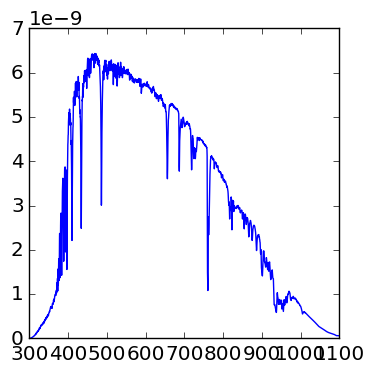

In [36]:
plt.plot(simwavelength,simspectra )

In [37]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        

        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [38]:
all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

In [39]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
def ShowSpectra(all_wavelength,all_simspec,all_simtitles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_simspec)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        wavelength=all_wavelength[index]
        spectrum=all_simspec[index]
        axarr[iy,ix].plot(wavelength,spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_simtitles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        axarr[iy,ix].grid(True)
      
    #title='spectra'
    #plt.suptitle(title,size=16)
   

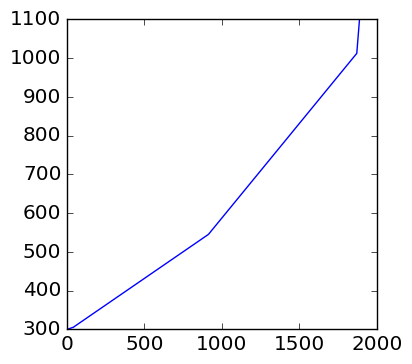

In [40]:
plt.plot(all_simwavelength[1])

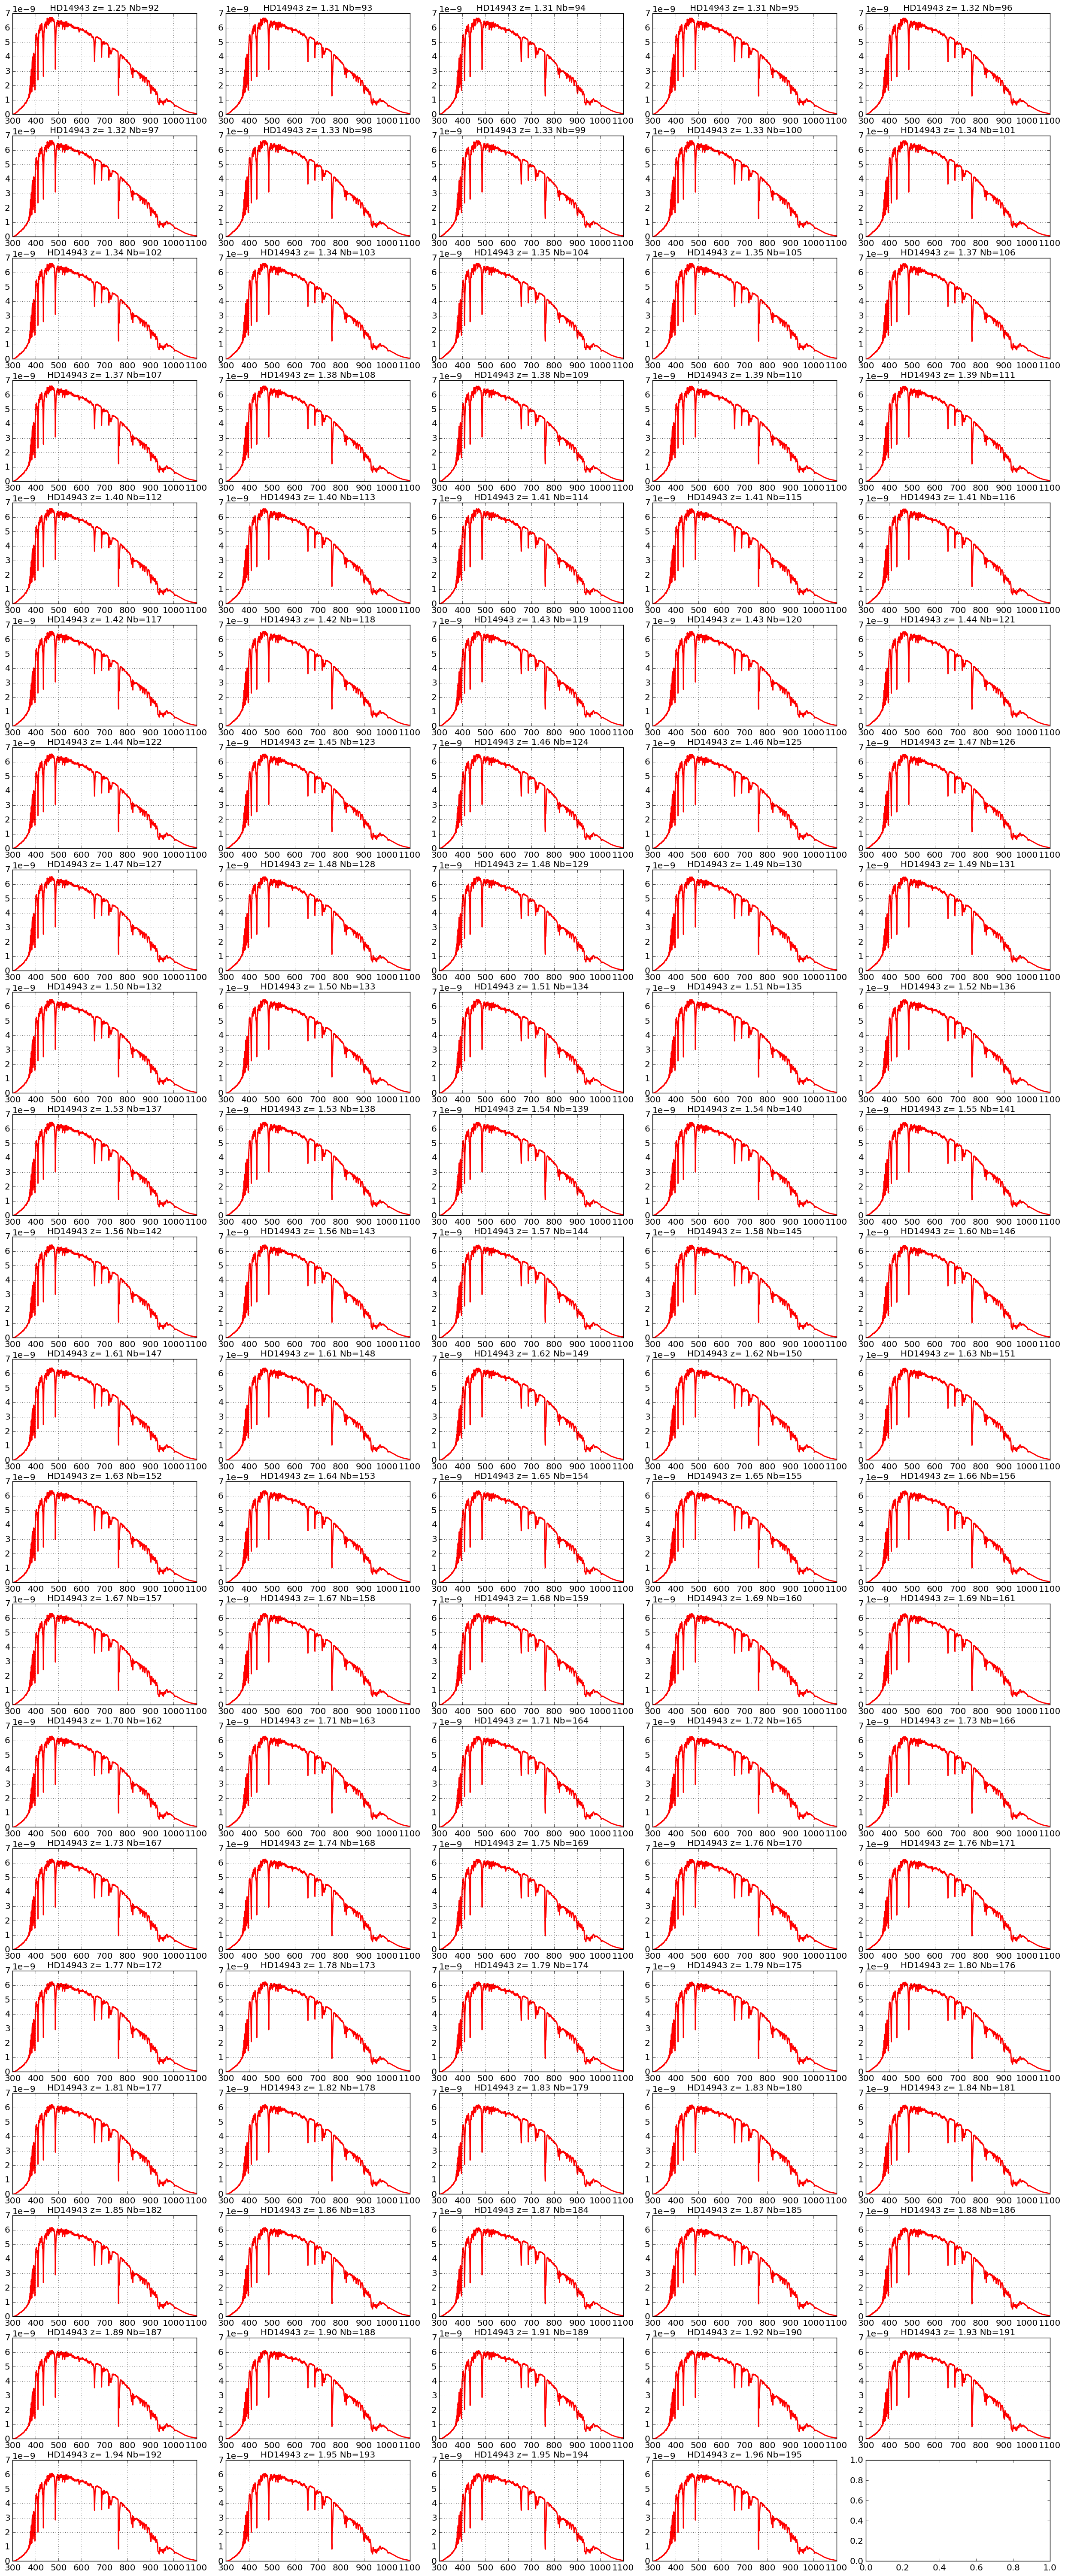

In [41]:
ShowSpectra(all_simwavelength,all_simspectra,all_simtitles,object_name)

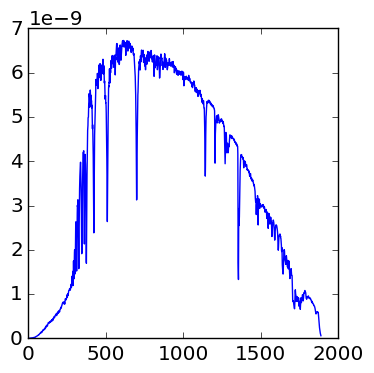

In [42]:
plt.plot(all_simspectra[0])

In [43]:
len(all_simwavelength[0])

1888

In [44]:
def MakeSimNpArray(all_simwavelength,all_simspectra):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=simwavelength.shape[0]
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=all_simspectra[ispec-1]
    return dataout
    

In [45]:
spectra_out=MakeSimNpArray(all_simwavelength,all_simspectra)

104  ,  1888


In [46]:
spectra_out.shape

(105, 1888)

In [47]:
spectra_out[0,:]

array([  300.01806641,   300.15505981,   300.29205322, ...,  1087.5       ,
        1092.5       ,  1097.5       ])

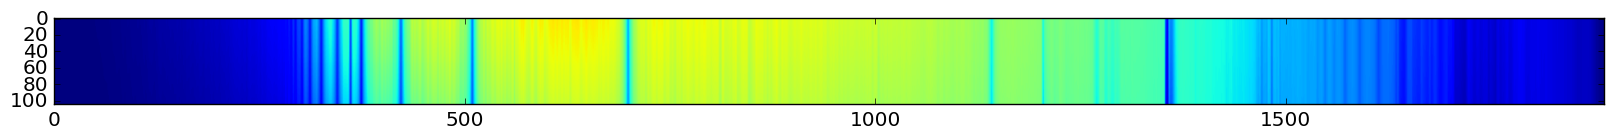

In [48]:
plt.figure(figsize=(20,20))
plt.imshow(spectra_out[:,:],vmin=0,vmax=1e-8)

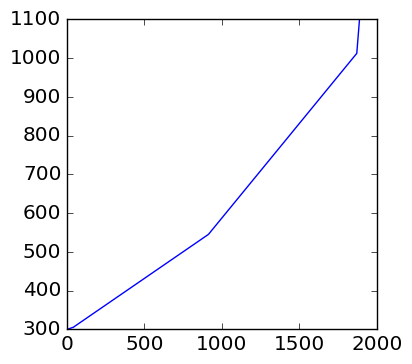

In [49]:
plt.plot(spectra_out[0,:])

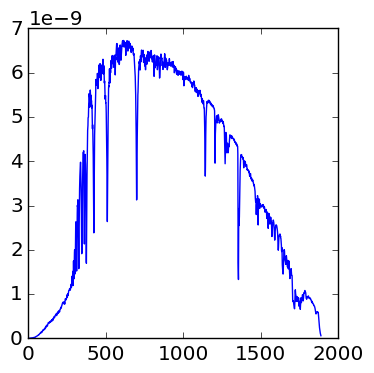

In [50]:
plt.plot(spectra_out[1,:])

### Save output fits file

In [51]:
prihdu = fits.PrimaryHDU(data=spectra_out)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfitsfile,clobber=True)